In [1]:
import os
import json
import warnings
import torch
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import geopandas as gpd
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Load the world shapefile provided by geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [3]:
# Set environment variables to help manage CUDA memory
os.environ['CUDA_VISIBLE_DEVICES'] = "MIG-214cfb66-c8e5-57f2-b101-90f2cca83fad"

torch.cuda.empty_cache()
torch.set_float32_matmul_precision('medium')

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NVIDIA A100 80GB PCIe MIG 4g.40gb


In [3]:
for root, dirs, files in os.walk('/home/serfani/serfani_data1/E3OMA1850'):
    
    sorted_files = sorted(files)
    list1 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'aijh1E3oma']     # Surface Flux (time, lat, lon)
    list2 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'aijlh1E3oma']    # Forcings (time, level, lat, lon)
    list3 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'cijlh1E3oma']    # Precipitation 3D (time, level, lat, lon)
    list4 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'taijlh1E3oma']   # Aerosols Mixing Ratio (time, level, lat, lon)
    list5 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'tNDaijh1E3oma']  # Clay_emission, BCB_biomass_src, OCB_biomass_src (time, lat, lon)
    list6 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'rijlh1E3oma']    # Cloud Fraction (time, level, lat, lon)

print(len(list1), len(list2), len(list3), len(list4), len(list5), len(list6))

1460 1460 1460 1460 1460 1460


## `gtempr, prsurf, pblht_bp, shflx, lhflx`

### Planetary boundary layer
- The region of the atmosphere in which the surface influences temperature, moisture, and wind velocity through the turbulent transfer of mass. As a result of surface friction, winds in the planetary boundary layer are usually weaker than above and tend to blow toward areas of low pressure.
- Under clear, sunny skies over land, the planetary boundary layer tends to be relatively deep as a result of the heating of the ground by the Sun and the resultant generation of convective turbulence.
- during clear, calm nights, turbulence tends to cease, and radiational cooling (net loss of heat) from the surface results in an air temperature that increases with height above the surface.
- Cloud formation within the troposphere cloud formation cloud formationCloud formation at various heights. The region above the planetary boundary layer is commonly known as the free atmosphere. Winds at this volume are not directly retarded by surface friction

### Latent/Sensible Heat Flux
- For the climate system to be in a steady state, the long-term average energy coming in must balance the long-term energy going out. At the surface, the amount of energy absorbed through radiation has to balance that lost through the combined effects of radiation, latent heat, and sensible heat.
- About two-thirds of incoming solar energy is absorbed by the surface, while the rest is absorbed by the atmosphere.
- Radiative transfer isn't the only way that energy moves between the surface and the atmosphere. The surface also loses energy through evapotranspiration from plants and wet surfaces (latent heat), and through conduction (sensible heat).
- Clouds reflect, absorb, and radiate energy.
- Vegetation strongly modulates energy flow by affecting albedo and evapotranspiration. (ours is prescribed emission, so this might not be that much important for the time being.)

In [5]:
ds1 = xr.open_mfdataset(list1[365:365+365])

warnings.filterwarnings("ignore", message="Converting a CFTimeIndex with dates from a non-standard calendar")
ds1['time'] = ds1.indexes['time'].to_datetimeindex()  # 365 x 48 -> 17520

ds1

<xarray.Dataset> Size: 5GB
Dimensions:   (time: 17520, lat: 90, lon: 144)
Coordinates:
  * lon       (lon) float32 576B -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * lat       (lat) float32 360B -90.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 90.0
  * time      (time) datetime64[ns] 140kB 1851-01-01T00:15:00 ... 1851-12-31T...
Data variables:
    axyp      (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    prsurf    (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    pblht_bp  (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    shflx     (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    lhflx     (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
Attributes:
    xlabel:   E3oma_ai_1850 tests (test run)

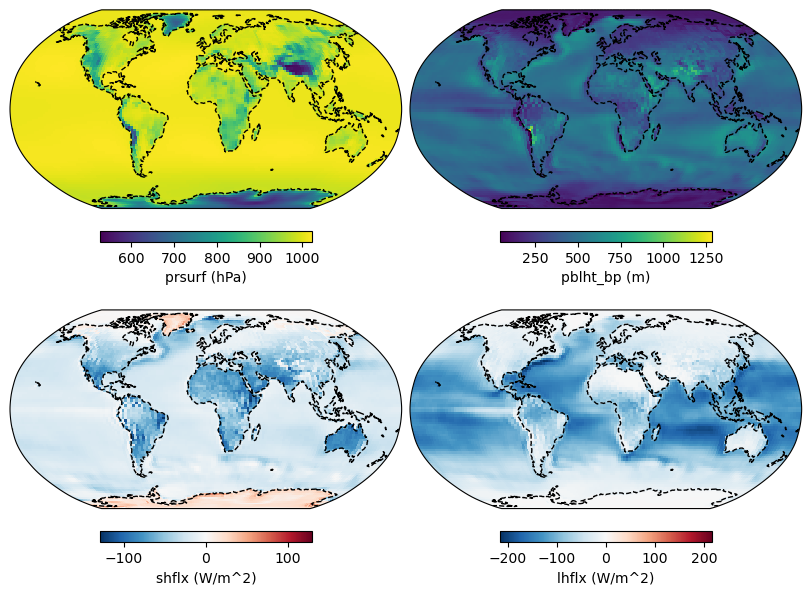

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

var1 = ["prsurf", "pblht_bp", "shflx", "lhflx"]
unit1 = ['hPa', 'm', 'W/m^2', 'W/m^2']

for idx, ax in enumerate(axs.flat):
    if idx < len(var1):  # Ensure we don't exceed the number of variables
        # Plot the data
        im = ds1[f'{var1[idx]}'].mean(axis=0).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
        
        # Add coastlines and borders
        ax.add_feature(cfeature.COASTLINE, linestyle='--')
        # ax.set_title(f'')
        
        # Add a color bar below each subplot
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
        cbar.set_label(f'{var1[idx]} ({unit1[idx]})')  # Label the color bar with the variable name
    else:
        # Turn off unused subplots
        ax.set_visible(False)

# Show the plot
plt.show()

In [10]:
weights = np.cos(np.deg2rad(ds1.lat))
weights.name = "weights"

ds1_avg = ds1.weighted(weights).mean(dim=("lat", "lon"))

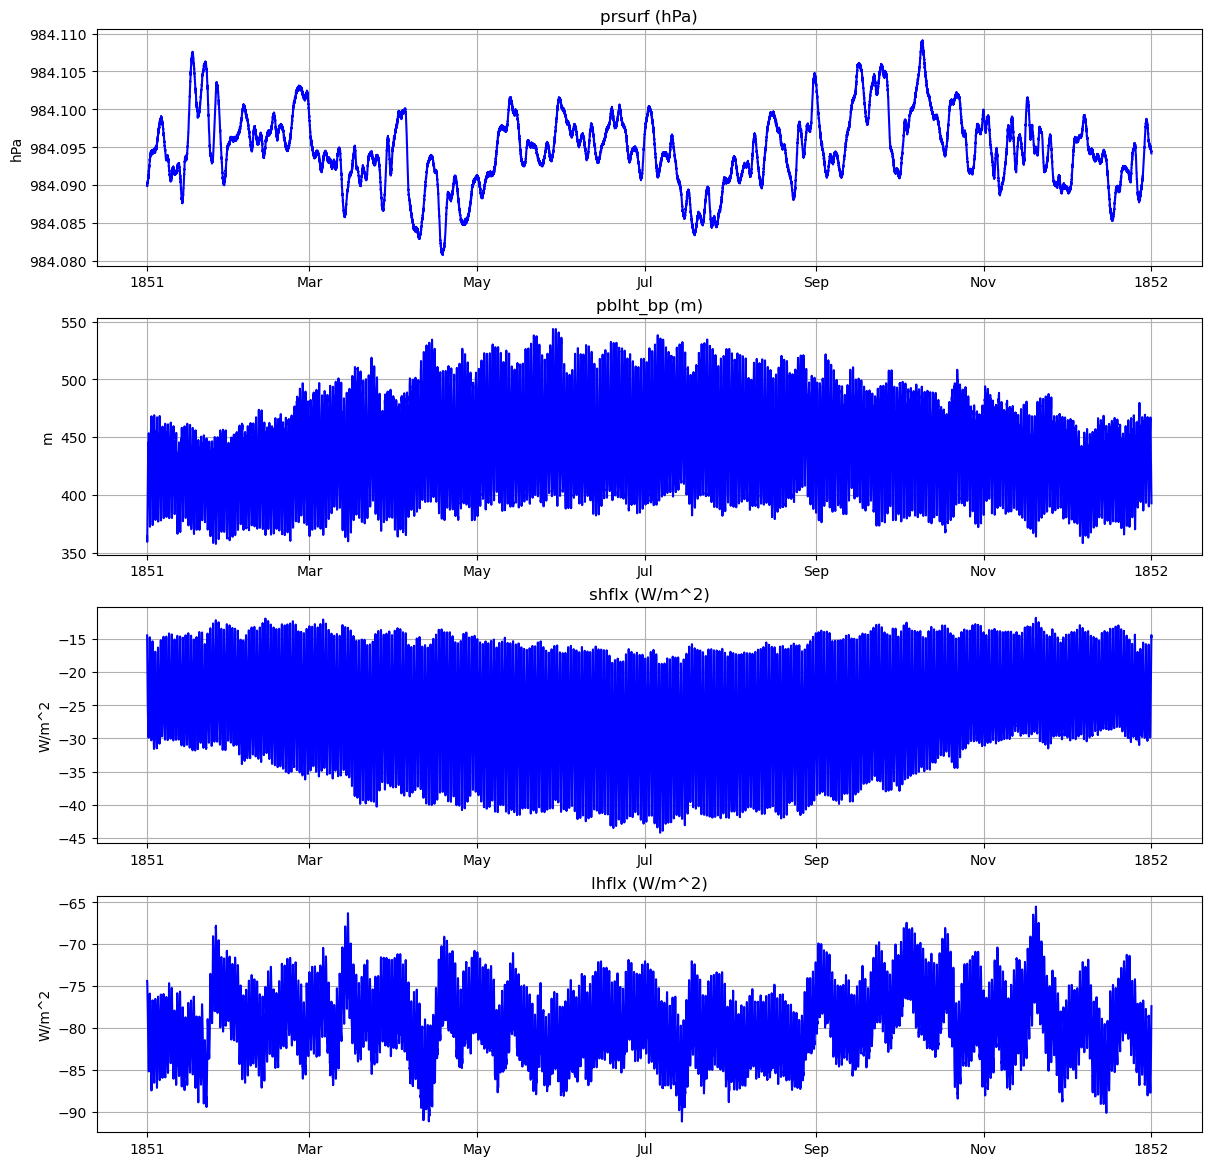

In [13]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 14), constrained_layout=True)

var1 = ["prsurf", "pblht_bp", "shflx", "lhflx"]
unit1 = ['hPa', 'm', 'W/m^2', 'W/m^2']

for idx, ax in enumerate(axs.flat):
    if idx < len(var1):  # Ensure we don't exceed the number of variables
        
        # Plot the time series
        ds1_avg[f'{var1[idx]}'].plot(ax=ax, label=f'{var1[idx]}', color='b')
        
        # Set titles and labels
        ax.set_title(f'{var1[idx]} ({unit1[idx]})')
        ax.set_xlabel('')
        ax.set_ylabel(f'{unit1[idx]}')
        ax.grid()
    else:
        # Turn off unused subplots
        ax.set_visible(False)

# Show the plot
plt.show()

### Forcings

In [7]:
ds2 = xr.open_mfdataset(list2[365:365+365])

warnings.filterwarnings("ignore", message="Converting a CFTimeIndex with dates from a non-standard calendar")
ds2['time'] = ds2.indexes['time'].to_datetimeindex()  # 365 x 48 -> 17520

ds2

<xarray.Dataset> Size: 451GB
Dimensions:  (time: 17520, lat: 90, lon: 144, level: 62)
Coordinates:
  * lon      (lon) float32 576B -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * lat      (lat) float32 360B -90.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 90.0
  * level    (level) float32 248B 1.0 2.0 3.0 4.0 5.0 ... 59.0 60.0 61.0 62.0
  * time     (time) datetime64[ns] 140kB 1851-01-01T00:15:00 ... 1851-12-31T2...
Data variables:
    axyp     (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    u        (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    v        (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    omega    (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    p_3d     (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    z        (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    t        (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    th       (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    q        (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
Attributes:
    xlabel:   E3oma_ai_1850 tests (test run)

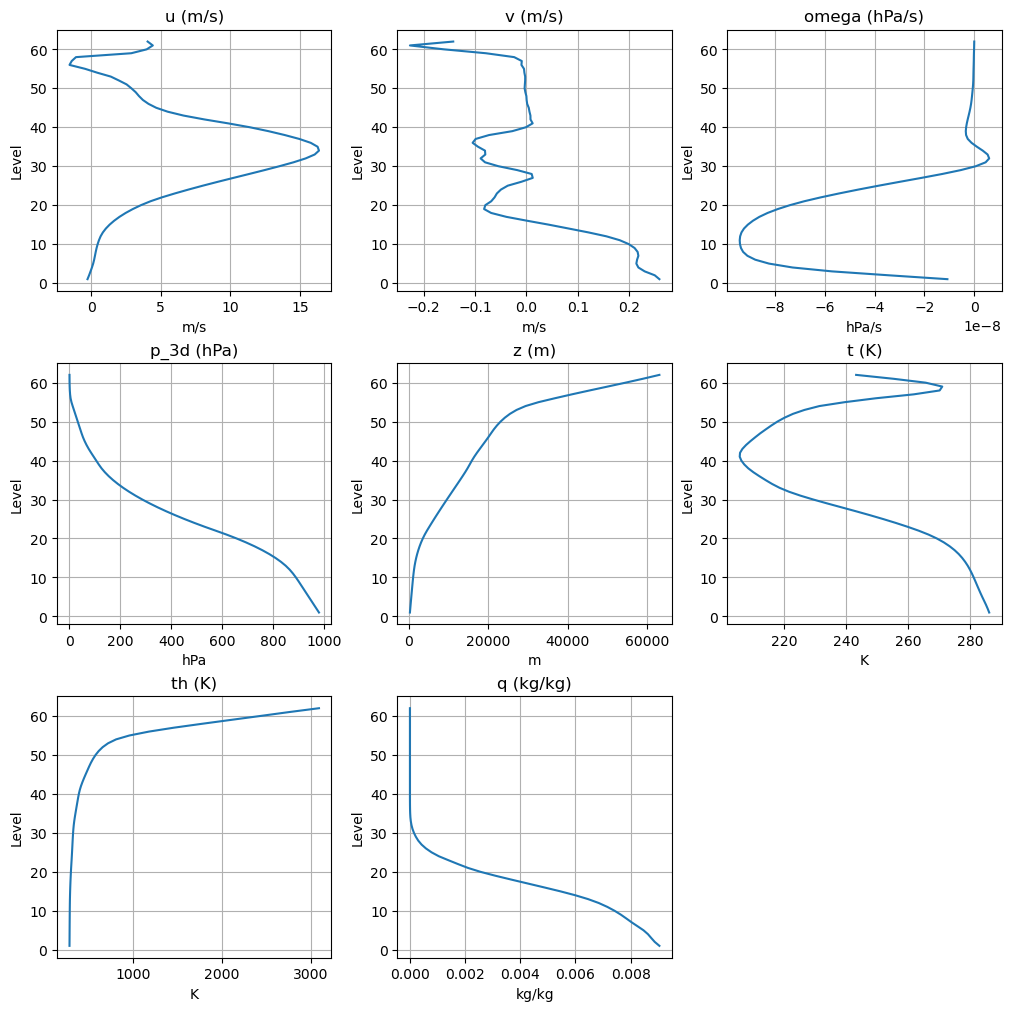

In [8]:
weights = np.cos(np.deg2rad(ds2.lat))
weights.name = "weights"

ds2_avg = ds2.weighted(weights).mean(dim=("lat", "lon", "time"))

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(10, 10), constrained_layout=True)

var2 = ["u", "v", "omega", "p_3d", "z", "t", "th", "q"]
unit2 = ['m/s', 'm/s', 'hPa/s', 'hPa', 'm', 'K', 'K', 'kg/kg']

for idx, ax in enumerate(axs.flat):
    if idx < len(var2):  # Ensure we don't exceed the number of variables
        
        # Plot the time series
        ds2_avg[f'{var2[idx]}'].plot(ax=ax, y='level', yincrease=True)
        
        # Set titles and labels
        ax.set_title(f'{var2[idx]} ({unit2[idx]})')
        ax.set_xlabel(f'{unit2[idx]}')
        ax.set_ylabel('Level')
        ax.grid()
    else:
        # Turn off unused subplots
        ax.set_visible(False)

plt.show()

###

In [5]:
ds4 = xr.open_mfdataset(list4[365:365+365],  engine='netcdf4', chunks={'time': 48, 'lat': 90, 'lon': 144, 'level': 62})

# warnings.filterwarnings("ignore", message="Converting a CFTimeIndex with dates from a non-standard calendar")
# ds4['time'] = ds4.indexes['time'].to_datetimeindex()  # 365 x 48 -> 17520

ds4

<xarray.Dataset> Size: 282GB
Dimensions:   (time: 17520, lat: 90, lon: 144, level: 62)
Coordinates:
  * lon       (lon) float32 576B -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * lat       (lat) float32 360B -90.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 90.0
  * level     (level) float32 248B 1.0 2.0 3.0 4.0 5.0 ... 59.0 60.0 61.0 62.0
  * time      (time) object 140kB 1851-01-01 00:15:00 ... 1851-12-31 23:45:00
Data variables:
    axyp      (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    Clay      (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    seasalt1  (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    BCB       (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    OCB       (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    airmass   (time, level, lat, lon) float32 56GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
Attributes:
    xlabel:   E3oma_ai_1850 tests (test run)

In [6]:
weights = np.cos(np.deg2rad(ds4.lat))
weights.name = "weights"

ds4_avg = ds4.weighted(weights).mean(dim=("lat", "lon"))
ds4_avg = ds4_avg.compute()

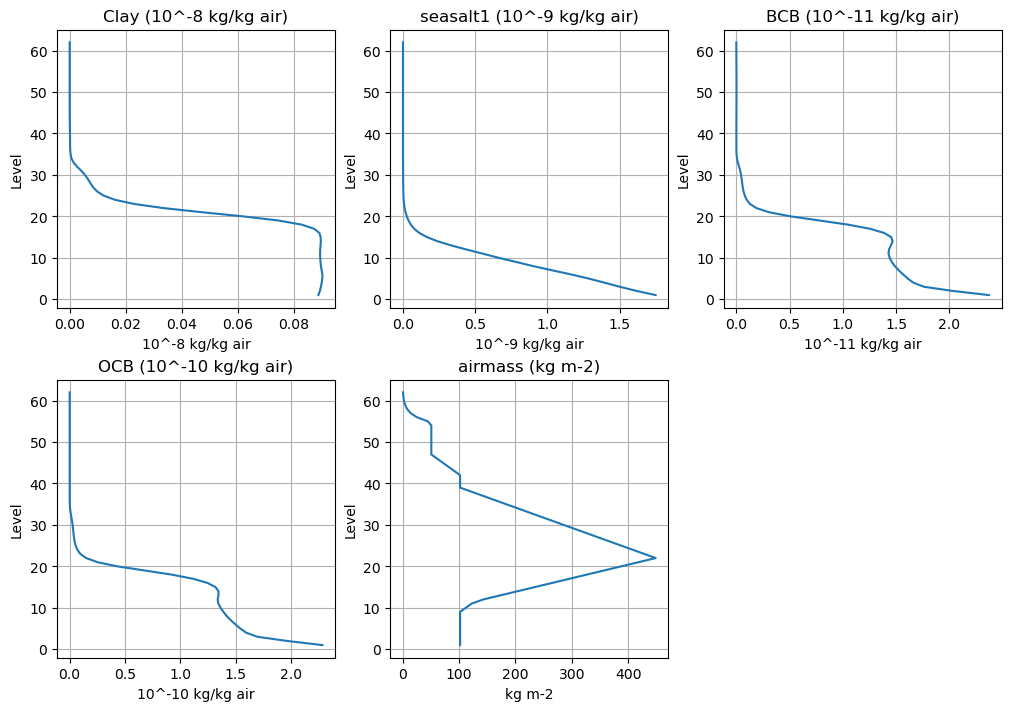

In [7]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10, 7), constrained_layout=True)

ds4_avg = ds4_avg.mean(dim="time")

var4 = ["Clay", "seasalt1", "BCB", "OCB", "airmass"]
unit4 = ['10^-8 kg/kg air', '10^-9 kg/kg air', '10^-11 kg/kg air', '10^-10 kg/kg air', 'kg m-2']


for idx, ax in enumerate(axs.flat):
    if idx < len(var4):  # Ensure we don't exceed the number of variables
        
        # Plot the time series
        ds4_avg[f'{var4[idx]}'].plot(ax=ax, y='level', yincrease=True)
        
        # Set titles and labels
        ax.set_title(f'{var4[idx]} ({unit4[idx]})')
        ax.set_xlabel(f'{unit4[idx]}')
        ax.set_ylabel('Level')
        ax.grid()
    else:
        # Turn off unused subplots
        ax.set_visible(False)

plt.show()

In [ ]:
ds4_avg = ds4.mean(dim=("time"))

fig, axs = plt.subplots(ncols=4, nrows=10, figsize=(12, 20), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

for idx, ax in enumerate(axs.flat):
    # Plot the data
    ds4_avg['BCB'].isel(level=idx).pipe(np.log).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)

    # Add coastlines and borders
    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_title(f'Level {idx}')

# Show the plot
plt.show()

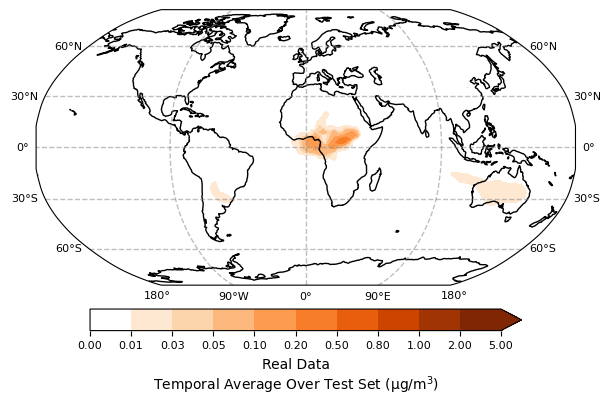

In [16]:
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

ax1.coastlines()

# Get the data for the current level
data1 = ds4['BCB'].isel(level=20).mean(dim=("time")).values
data1 = data1 * 0.01 * 1.25

# Define stepwise colors and corresponding boundaries
colors = plt.cm.Oranges(np.linspace(0, 1, 10))  # Adjust colors as needed
colors[0] = [1, 1, 1, 1]  # Set the first color to white
bounds = np.linspace(0, .1, 11)  # Define boundaries
# bounds[1] = 0.01
bounds = [0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5]

# Create a colormap and normalization
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds4['lon'], ds4['lat'])

# Plot the data using pcolormesh, which works better with projections
# im1 = ax1.pcolormesh(
#     lon, lat, data1,
#     transform=ccrs.PlateCarree(),
#     # cmap='gist_heat_r',
#     cmap=cmap, norm=norm,
# )

im1 = ax1.contourf(
    lon, lat, data1,
    transform=ccrs.PlateCarree(),
    levels=bounds, 
    cmap=cmap, norm=norm, extend='max'
)


gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl1.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

gl1.xlabel_style = {'size': 8}  # Adjust the font size for x-axis labels
gl1.ylabel_style = {'size': 8} 

gl1.top_labels = False
# gl1.bottom_labels = False
# gl1.left_labels = False
# gl1.right_labels = False


# Add an individual colorbar for each subplot
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.02, shrink=0.8, extend='max')
cbar.set_label('Real Data' '\n' r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
cbar.set_ticks(bounds)  # Explicitly set the ticks


plt.show()

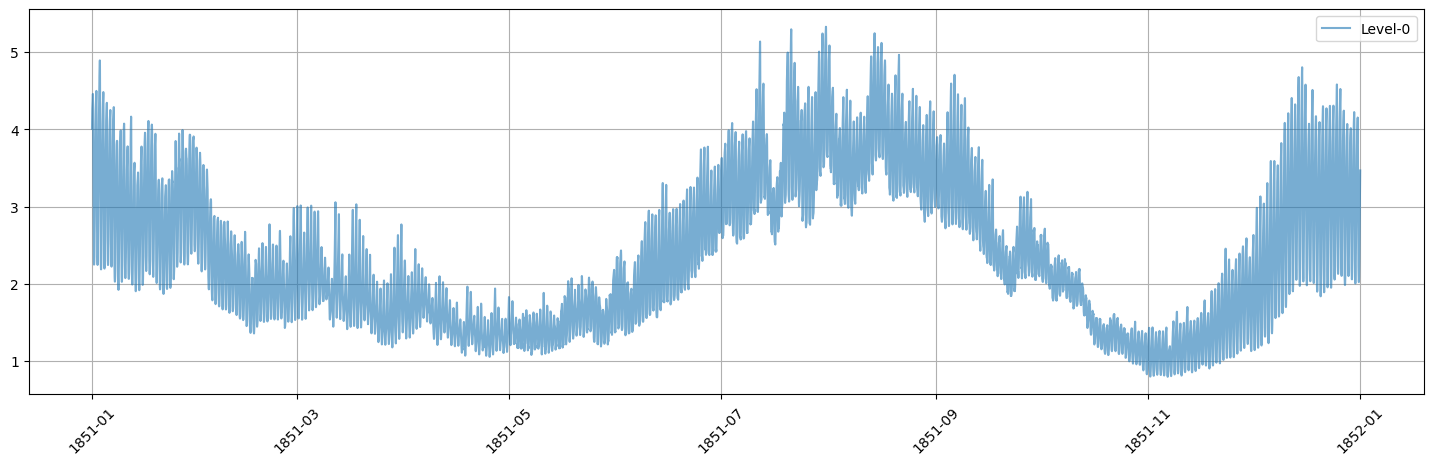

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

ax.plot(ds4_avg.indexes['time'], ds4_avg['BCB'].isel(level=0), alpha=0.6, label='Level-0')
# ax.plot(ds4_avg.indexes['time'][:96], ds4_avg['BCB'][:96].isel(level=1), alpha=0.6, label='Level-1')
# ax.plot(ds4_avg.indexes['time'][:96], ds4_avg['BCB'][:96].isel(level=2), alpha=0.6, label='Level-2')
# ax.plot(ds4_avg.indexes['time'][:96], ds4_avg['BCB'][:96].isel(level=3), alpha=0.6, label='Level-3')
# ax.plot(ds4_avg.indexes['time'][:96], ds4_avg['BCB'][:96].isel(level=4), alpha=0.6, label='Level-4')
# ax.plot(ds4_avg.indexes['time'][:96], ds4_avg['BCB'][:96].isel(level=5), alpha=0.6, label='Level-5')
# ax.plot(ds4_avg.indexes['time'][:96], ds4_avg['BCB'][:96].isel(level=6), alpha=0.6, label='Level-6')

ax.tick_params(axis='x', labelrotation=45)
ax.grid()

plt.legend()
plt.show()

In [4]:
ds5 = xr.open_mfdataset(list5[365:365+365])

warnings.filterwarnings("ignore", message="Converting a CFTimeIndex with dates from a non-standard calendar")
ds5['time'] = ds5.indexes['time'].to_datetimeindex()  # 365 x 48 -> 17520

ds5

<xarray.Dataset> Size: 4GB
Dimensions:          (time: 17520, lat: 90, lon: 144)
Coordinates:
  * lon              (lon) float32 576B -178.8 -176.2 -173.8 ... 176.2 178.8
  * lat              (lat) float32 360B -90.0 -87.0 -85.0 ... 85.0 87.0 90.0
  * time             (time) datetime64[ns] 140kB 1851-01-01T00:15:00 ... 1851...
Data variables:
    axyp             (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    Clay_emission    (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    BCB_biomass_src  (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    OCB_biomass_src  (time, lat, lon) float32 908MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
Attributes:
    xlabel:   E3oma_ai_1850 tests (test run)

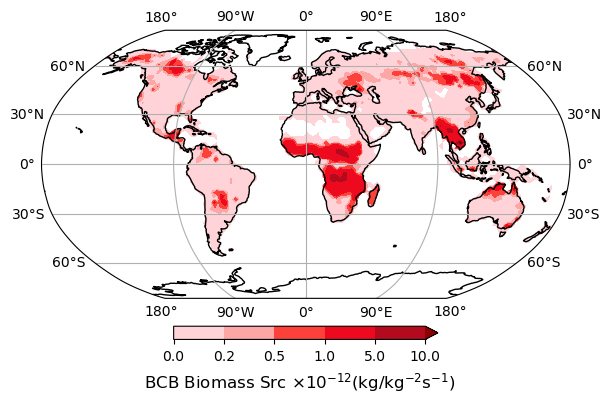

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds5['lon'], ds5['lat'])

data = ds5['BCB_biomass_src'].mean(dim='time')
data = np.where(data <= 0.0, np.nan, data)
ax.coastlines()

colors = [(0.0, 'mistyrose'), (0.025, 'pink'), (0.05, 'salmon'), (0.1, 'red'), (0.5, 'crimson'), (1.0, 'darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

im = ax.contourf(
    lon, lat, data,
    transform=ccrs.PlateCarree(),
    levels=[0, 0.25, 0.5, 1.0, 5.0, 10], 
    cmap=cmap, extend='max'
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.5)
cbar.set_label(r'BCB Biomass Src $ \times 10^{-12} (\mathrm{kg} / \mathrm{kg}^{-2} \mathrm{s}^{-1}$)', rotation=0, labelpad=5, fontsize=12)
cbar.ax.tick_params(labelsize=10)  # Adjust the font size here
cbar.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

plt.show()

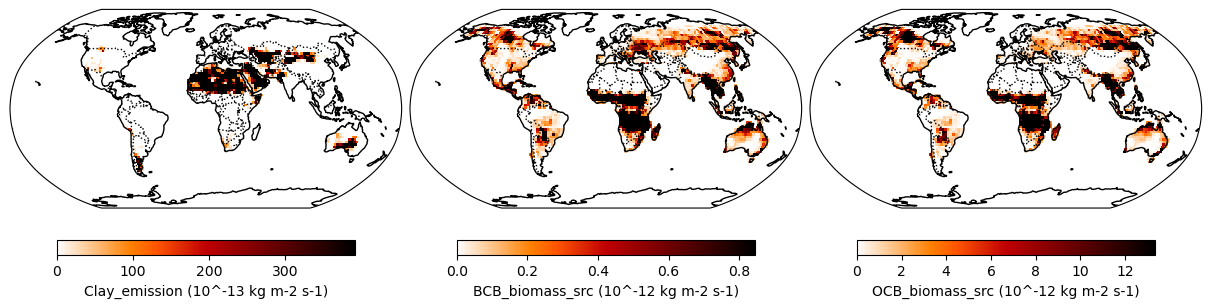

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

var5 = ["Clay_emission", "BCB_biomass_src", "OCB_biomass_src"]
unit5 = ['10^-13 kg m-2 s-1', '10^-12 kg m-2 s-1', '10^-12 kg m-2 s-1']

for idx, ax in enumerate(axs.flat):
    if idx < len(var5):  # Ensure we don't exceed the number of variables
        # Plot the data
        im = ds5[f'{var5[idx]}'].mean(axis=0).plot(ax=ax,  transform=ccrs.PlateCarree(), robust=True, cmap='gist_heat_r', add_colorbar=False)
        
        # Add coastlines and borders
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        # ax.set_title(f'')
        
        # Add a color bar below each subplot
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
        cbar.set_label(f'{var5[idx]} ({unit5[idx]})')  # Label the color bar with the variable name
    else:
        # Turn off unused subplots
        ax.set_visible(False)

# Show the plot
plt.show()

In [5]:
weights = np.cos(np.deg2rad(ds5.lat))
weights.name = "weights"

ds5_avg = ds5.weighted(weights).mean(dim=("lat", "lon"))

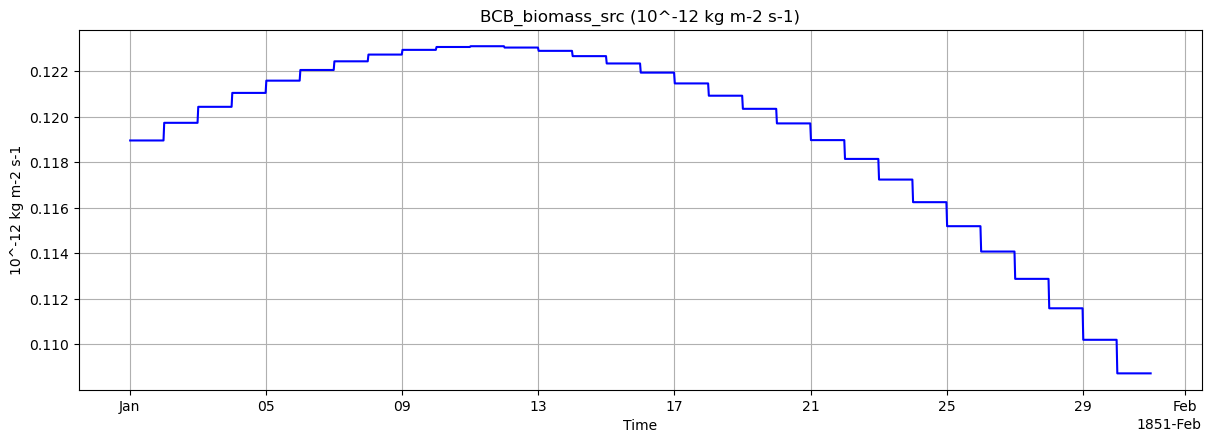

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), constrained_layout=True)

var5 = ["BCB_biomass_src"]
unit5 = ['10^-12 kg m-2 s-1']

for idx, ax in enumerate(axs.flat):
    if idx < len(var5):  # Ensure we don't exceed the number of variables
        
        # Plot the time series
        ds5_avg[f'{var5[idx]}'][:48*30].plot(ax=ax, label=f'{var5[idx]}', color='b')
        
        # Set titles and labels
        ax.set_title(f'{var5[idx]} ({unit5[idx]})')
        ax.set_xlabel('Time')
        ax.set_ylabel(f'{unit5[idx]}')
        ax.grid()
    else:
        # Turn off unused subplots
        ax.set_visible(False)

# Show the plot
plt.show()

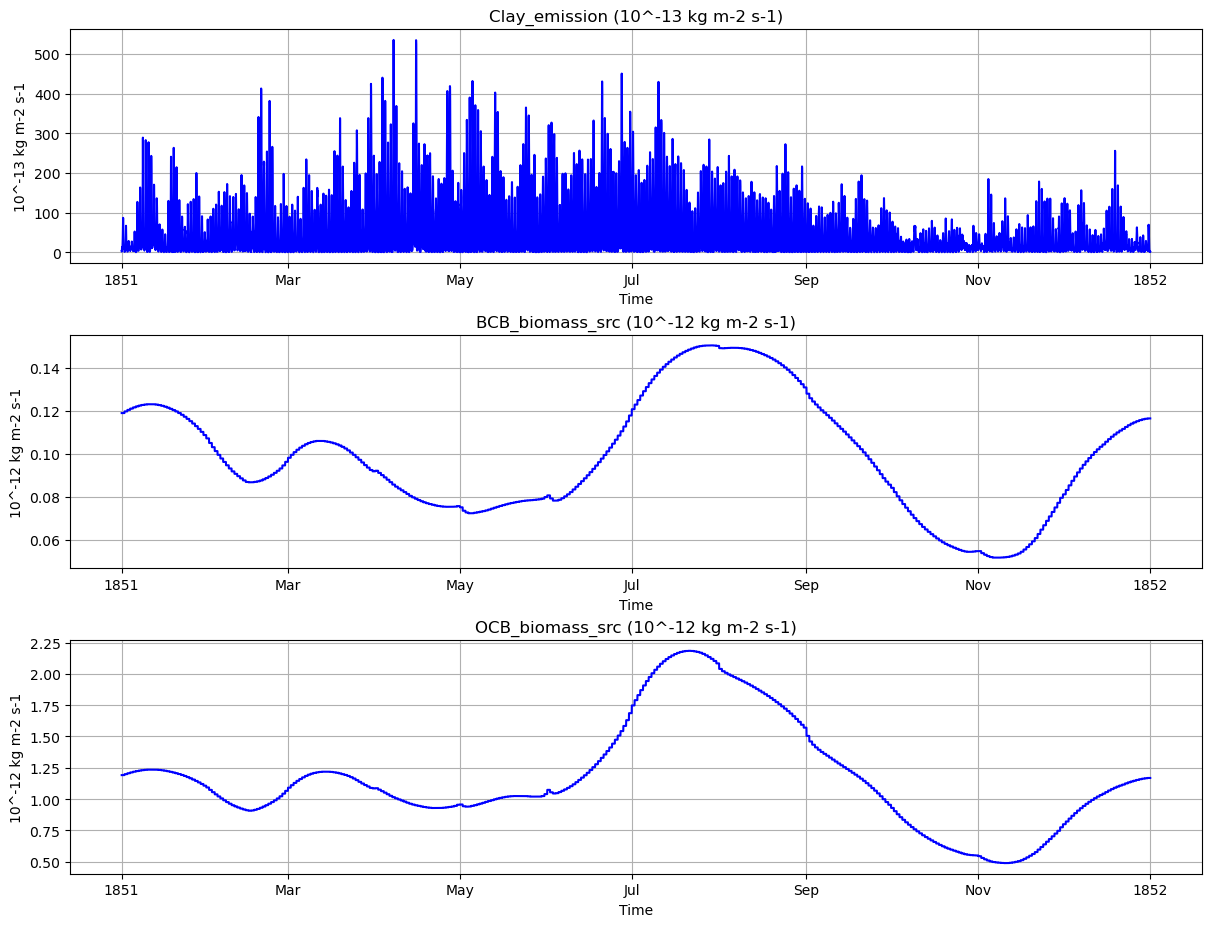

In [21]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 14), constrained_layout=True)

var5 = ["Clay_emission", "BCB_biomass_src", "OCB_biomass_src"]
unit5 = ['10^-13 kg m-2 s-1', '10^-12 kg m-2 s-1', '10^-12 kg m-2 s-1']

for idx, ax in enumerate(axs.flat):
    if idx < len(var5):  # Ensure we don't exceed the number of variables
        
        # Plot the time series
        ds5_avg[f'{var5[idx]}'].plot(ax=ax, label=f'{var5[idx]}', color='b')
        
        # Set titles and labels
        ax.set_title(f'{var5[idx]} ({unit5[idx]})')
        ax.set_xlabel('Time')
        ax.set_ylabel(f'{unit5[idx]}')
        ax.grid()
    else:
        # Turn off unused subplots
        ax.set_visible(False)

# Show the plot
plt.show()

### Calculation of descriptive statistics of input/output variables

In [9]:
ds = xr.open_mfdataset(list6[365:365+3])
ds

<xarray.Dataset> Size: 470MB
Dimensions:  (time: 144, lat: 90, lon: 144, level: 62)
Coordinates:
  * lon      (lon) float32 576B -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * lat      (lat) float32 360B -90.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 90.0
  * level    (level) float32 248B 1.0 2.0 3.0 4.0 5.0 ... 59.0 60.0 61.0 62.0
  * time     (time) object 1kB 1851-01-01 00:15:00 ... 1851-01-03 23:45:00
Data variables:
    axyp     (time, lat, lon) float32 7MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    cfrad    (time, level, lat, lon) float32 463MB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
Attributes:
    xlabel:   E3oma_ai_1850 tests (test run)

avg1: 24.8843, std1: 43.2342
avg2: 16.1301, std2: 36.7808
avg3: 16.1499, std3: 36.7991


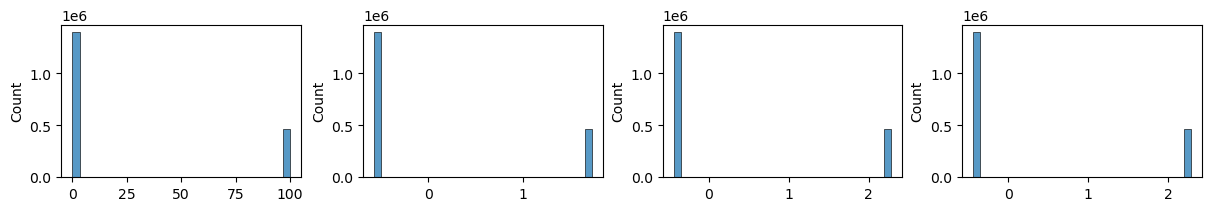

In [10]:
# Histogram
from scipy.stats import skew, kurtosis, zscore
import seaborn as sns

weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

v = ds['cfrad'].isel(level=0)
area = ds['axyp']

avg1 = v.mean(dim=("lat", "lon", "time")).values
std1 = v.std(dim=("lat", "lon", "time")).values
avg2 = v.weighted(weights).mean(dim=("lat", "lon", "time")).values
std2 = v.weighted(weights).std(dim=("lat", "lon", "time")).values

weighted_mean = np.average(v.values, weights=area.values)
weighted_std = np.sqrt(np.average((v.values - weighted_mean)**2, weights=area.values))

print(f'avg1: {avg1:.4f}, std1: {std1:.4f}')
print(f'avg2: {avg2:.4f}, std2: {std2:.4f}')
print(f'avg3: {weighted_mean:.4f}, std3: {weighted_std:.4f}')

v1 = (v.values - avg1) / std1
v2 = (v.values - avg2) / std2 
v3 = (v.values - weighted_mean) / weighted_std

fig, axs = plt.subplots(nrows=1, ncols=4 , figsize=(12,2), constrained_layout=True)

sns.histplot(x=v.values.flatten(), bins=30, ax=axs[0])
sns.histplot(x=v1.flatten(), bins=30, ax=axs[1])
sns.histplot(x=v2.flatten(), bins=30, ax=axs[2])
sns.histplot(x=v3.flatten(), bins=30, ax=axs[3])

plt.show()

In [ ]:
data = list()

ds1 = xr.open_mfdataset(list1[365:365+876])

weights = np.cos(np.deg2rad(ds1.lat))
weights.name = "weights"

data.append([ds1['prsurf'].weighted(weights).mean(dim=("lat", "lon", "time")).values.item(),   ds1['prsurf'].weighted(weights).std(dim=("lat", "lon", "time")).values.item()])
data.append([ds1['pblht_bp'].weighted(weights).mean(dim=("lat", "lon", "time")).values.item(), ds1['pblht_bp'].weighted(weights).std(dim=("lat", "lon", "time")).values.item()])
data.append([ds1['shflx'].weighted(weights).mean(dim=("lat", "lon", "time")).values.item(),    ds1['shflx'].weighted(weights).std(dim=("lat", "lon", "time")).values.item()])
data.append([ds1['lhflx'].weighted(weights).mean(dim=("lat", "lon", "time")).values.item(),    ds1['lhflx'].weighted(weights).std(dim=("lat", "lon", "time")).values.item()])
print('ds1 is done')

ds5 = xr.open_mfdataset(list5[365:365+876])
data.append([ds5['BCB_biomass_src'].weighted(weights).mean(dim=("lat", "lon", "time")).values.item(),    ds5['BCB_biomass_src'].weighted(weights).std(dim=("lat", "lon", "time")).values.item()])
print('ds5 is done')

ds2 = xr.open_mfdataset(list2[365:365+876])
data.append([ds2['u'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds2['u'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['v'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds2['v'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['omega'].weighted(weights).mean(dim=("lat", "lon", "time")).values, ds2['omega'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['p_3d'].weighted(weights).mean(dim=("lat", "lon", "time")).values,  ds2['p_3d'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['z'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds2['z'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['t'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds2['t'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['th'].weighted(weights).mean(dim=("lat", "lon", "time")).values,    ds2['th'].weighted(weights).std(dim=("lat", "lon", "time")).values])
data.append([ds2['q'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds2['q'].weighted(weights).std(dim=("lat", "lon", "time")).values])
print('ds2 is done')

ds3 = xr.open_mfdataset(list3[365:365+876])
data.append([ds3['prec_3d_sum'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds3['prec_3d_sum'].weighted(weights).std(dim=("lat", "lon", "time")).values])
print('ds3 is done')


ds4 = xr.open_mfdataset(list4[365:365+876])
data.append([ds4['BCB'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds4['BCB'].weighted(weights).std(dim=("lat", "lon", "time")).values])
print('ds4 is done')

ds6 = xr.open_mfdataset(list6[365:365+876])
data.append([ds6['cfrad'].weighted(weights).mean(dim=("lat", "lon", "time")).values,     ds6['cfrad'].weighted(weights).std(dim=("lat", "lon", "time")).values])
print('ds6 is done')


ds1 is done
ds5 is done
ds2 is done
ds3 is done
ds4 is done
ds6 is done


In [42]:

variables = ['prsurf', 'pblht_bp', 'shflx', 'lhflx', 'BCB_biomass_src', 'u', 'v', 'omega', 'p_3d', 'z', 't', 'th', 'q', 'prec_3d_sum', 'BCB', 'cfrad']
result = {}

for idx, key in enumerate(variables):

    avg, std = data[idx]
    result[key] = {
        'avg': avg.tolist() if isinstance(avg, np.ndarray) else avg,
        'std': std.tolist() if isinstance(std, np.ndarray) else std
    }

with open('variable_statistics1.json', 'w') as jf:
    json.dump(result, jf, indent=4)


### Plot global average of conc. on pressure levels 

In [41]:
ds4 = xr.open_mfdataset(list4[365:365+30], engine='netcdf4', chunks={'time': 48, 'lat': 90, 'lon': 144, 'level': 62})

weights = np.cos(np.deg2rad(ds4.lat))
weights.name = "weights"

warnings.filterwarnings("ignore", message="Converting a CFTimeIndex with dates from a non-standard calendar")
ds4['time'] = ds4.indexes['time'].to_datetimeindex()  # 365 x 48 -> 17520

ds5_avg = ds4.weighted(weights).mean(dim=("lat", "lon"))

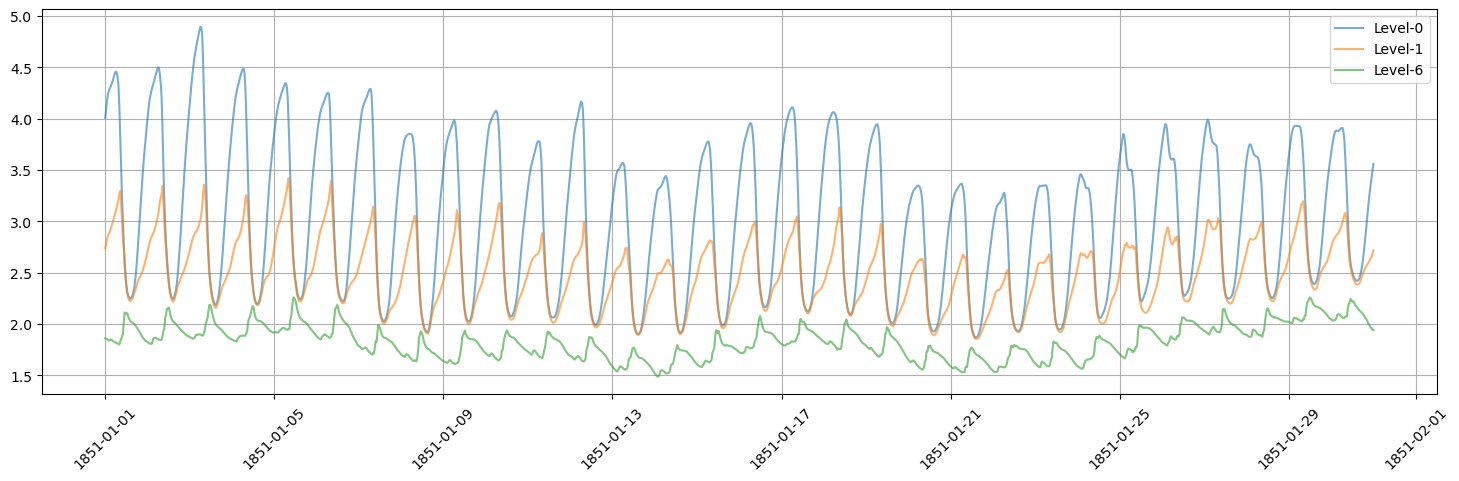

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

ax.plot(ds5_avg.indexes['time'], ds5_avg['BCB'].isel(level=0), alpha=0.6, label='Level-0')
ax.plot(ds5_avg.indexes['time'], ds5_avg['BCB'].isel(level=1), alpha=0.6, label='Level-1')
# ax.plot(ds5_avg.indexes['time'], ds5_avg['BCB'].isel(level=2), alpha=0.6, label='Level-2')
ax.plot(ds5_avg.indexes['time'], ds5_avg['BCB'].isel(level=6), alpha=0.6, label='Level-6')

ax.tick_params(axis='x', labelrotation=45)
ax.grid()

plt.legend()
plt.show()

In [43]:
def get_random_samples(data, samples=10000):
    data = data.values.ravel()
    idx = np.arange(len(data))

    rng = np.random.default_rng(42)
    rng.shuffle(idx)

    return data[idx[:samples]]

data_list = [get_random_samples(ds5_avg['BCB'].isel(level=i), samples=10000) for i in range(30)]
levels = [f'level-{i}' for i in range(30)]

In [44]:
with open('../variable_statistics.json', 'r') as jf:
    st = json.load(jf)

y_avg = np.array(st['BCB']['avg'][:30], dtype=np.float32).reshape(30, 1)
y_std = np.array(st['BCB']['std'][:30], dtype=np.float32).reshape(30, 1)

In [45]:
data_arr = np.array(data_list)
data_arr = (data_arr - y_avg) / y_std

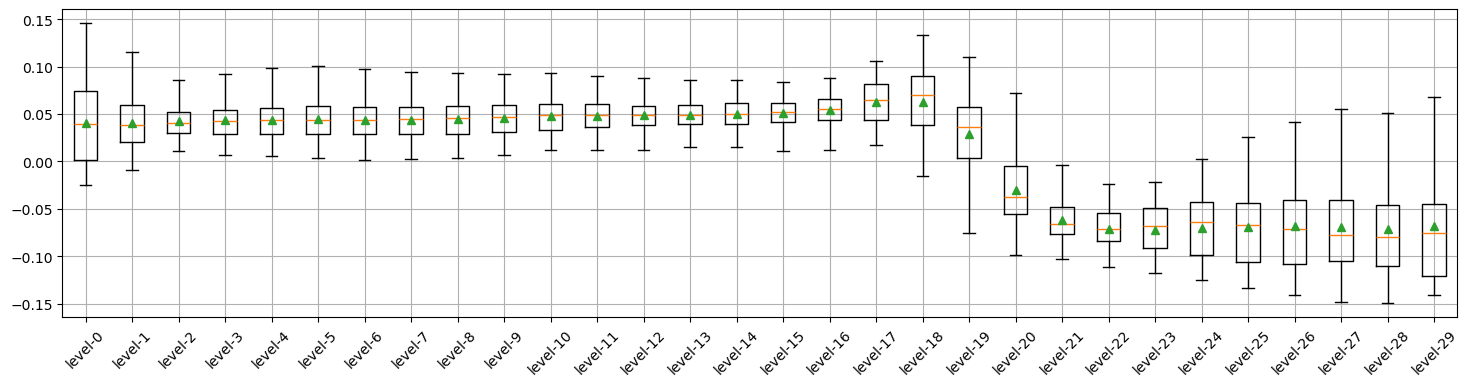

In [46]:
fig, ax = plt.subplots(figsize=(18, 4))

ax.boxplot([data_arr[i] for i in range(30)], showmeans=True, showfliers=False)
ax.set_xticklabels(levels, rotation=45)

ax.grid()

plt.show()

In [47]:
ds4_avg = ds4['BCB'].weighted(weights).mean(dim=("time")).compute()

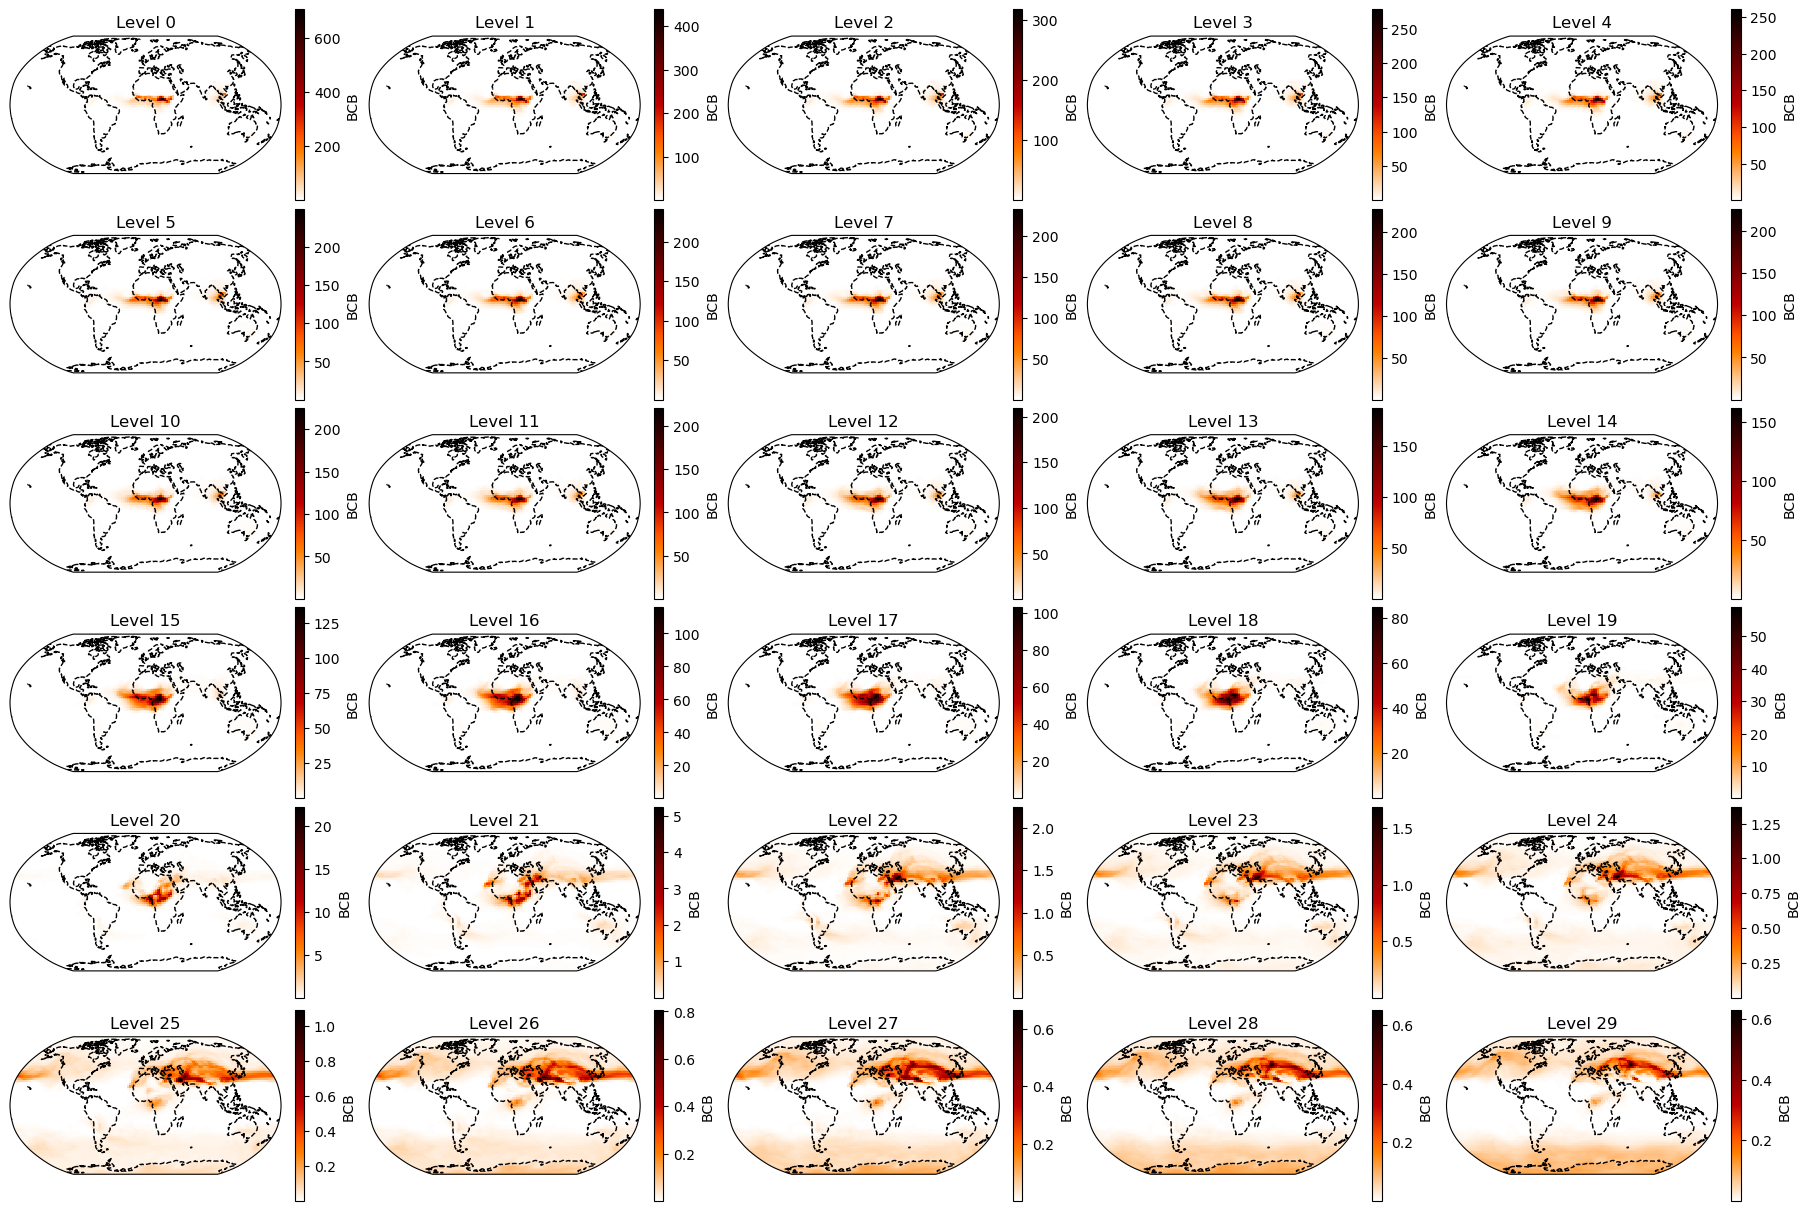

In [56]:

fig, axs = plt.subplots(ncols=5, nrows=6, figsize=(18, 12), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

for idx, ax in enumerate(axs.flat):
    # Plot the data
    ds4_avg.isel(level=idx).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=True,
                                                         cmap='gist_heat_r')

    # Add coastlines and borders
    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_title(f'Level {idx}')

# Show the plot
plt.show()

In [4]:
def sampelling(da, level=None):

    if level is not None:
        idx = np.arange(da.isel(level=level).size)
    else:
        idx = np.arange(da.size)

    rng = np.random.default_rng(0)
    rng.shuffle(idx)

    v = da.values.flatten()[idx[:10000]]
    
    return v

In [4]:
ds1 = xr.open_mfdataset(list1[365:365+30], engine='netcdf4', chunks={'time': 48, 'lat': 90, 'lon': 144, 'level': 62}) #.sel(lat=slice(5, 8), lon=slice(10, 30))
ds2 = xr.open_mfdataset(list2[365:365+30], engine='netcdf4', chunks={'time': 48, 'lat': 90, 'lon': 144, 'level': 62}) #.sel(lat=slice(5, 8), lon=slice(10, 30))
ds3 = xr.open_mfdataset(list3[365:365+30], engine='netcdf4', chunks={'time': 48, 'lat': 90, 'lon': 144, 'level': 62}) #.sel(lat=slice(5, 8), lon=slice(10, 30))
ds4 = xr.open_mfdataset(list4[365:365+30], engine='netcdf4', chunks={'time': 48, 'lat': 90, 'lon': 144, 'level': 62}) #.sel(lat=slice(5, 8), lon=slice(10, 30))
ds5 = xr.open_mfdataset(list5[365:365+30], engine='netcdf4', chunks={'time': 48, 'lat': 90, 'lon': 144, 'level': 62}) #.sel(lat=slice(5, 8), lon=slice(10, 30))
ds6 = xr.open_mfdataset(list6[365:365+30], engine='netcdf4', chunks={'time': 48, 'lat': 90, 'lon': 144, 'level': 62}) #.sel(lat=slice(5, 8), lon=slice(10, 30))

In [6]:
# Get available lat and lon values
lat_vals = ds2.lat.values
lon_vals = ds2.lon.values

# Randomly choose 20 unique indices
np.random.seed(42)  # optional for reproducibility
random_lats = np.random.choice(lat_vals, size=6, replace=False)
random_lons = np.random.choice(lon_vals, size=8, replace=False)

# Now select these using .sel with method='nearest'
ds2 = ds2.sel(lat=random_lats, lon=random_lons, method="nearest")
ds3 = ds3.sel(lat=random_lats, lon=random_lons, method="nearest")
ds4 = ds4.sel(lat=random_lats, lon=random_lons, method="nearest")
ds6 = ds6.sel(lat=random_lats, lon=random_lons, method="nearest")

In [7]:
df2 = ds2[["u", "v", "omega", "p_3d", "z", "t", "th", "q"]].to_dataframe(dim_order=['lat', 'lon', 'time', 'level']).reset_index()
df3 = ds3[["prec_3d_sum"]].to_dataframe(dim_order=['lat', 'lon', 'time', 'level']).reset_index()
df4 = ds4[["BCB"]].to_dataframe(dim_order=['lat', 'lon', 'time', 'level']).reset_index()
df6 = ds6[["cfrad"]].to_dataframe(dim_order=['lat', 'lon', 'time', 'level']).reset_index()

In [8]:
join_keys = ['lat', 'lon', 'time', 'level']
df = df2.merge(df3, on=join_keys, how='inner')\
        .merge(df4, on=join_keys, how='inner')\
        .merge(df6, on=join_keys, how='inner')

In [73]:
level = 0

data = {
    'prsurf': sampelling(ds1['prsurf']),
    'pblht_bp': sampelling(ds1['pblht_bp']),
    'shflx': sampelling(ds1['shflx']),
    'lhflx': sampelling(ds1['lhflx']),
    'axyp': sampelling(ds2['axyp']),
    'u': sampelling(ds2['u'], level),
    'v': sampelling(ds2['v'], level),
    'omega': sampelling(ds2['omega'], level),
    'p_3d': sampelling(ds2['p_3d'], level),
    'z': sampelling(ds2['z'], level),
    't': sampelling(ds2['t'], level),
    'th': sampelling(ds2['th'], level),
    'q': sampelling(ds2['q'], level),
    'prec_3d_sum': sampelling(ds3['prec_3d_sum'], level),
    'BCB': sampelling(ds4['BCB'], level),
    'BCB_biomass_src': sampelling(ds5['BCB_biomass_src']),
    'cfrad': sampelling(ds6['cfrad'], level),
}

# Create DataFrame
df = pd.DataFrame(data)

df.describe()


prsurf      pblht_bp         shflx         lhflx          axyp  \
count  10000.000000  10000.000000  10000.000000  10000.000000  1.000000e+04   
mean     964.757202    352.768829    -18.888533    -61.242962  3.923243e+10   
std       91.509438    365.464050     57.281879     81.945160  1.921891e+10   
min      519.752930     30.479561   -594.872498   -739.732239  1.078880e+09   
25%      970.585571     42.400352    -21.036626   -103.447859  2.215374e+10   
50%     1000.453339    289.433838     -6.799202    -22.268052  4.371223e+10   
75%     1011.901978    504.576668      3.149735     -1.377416  5.690416e+10   
max     1036.599243   3484.915283    103.349174    114.239532  6.180900e+10   

                  u             v         omega          p_3d             z  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       4.650635      0.335460     -0.000011    388.949463  14433.471680   
std       16.055851      8.602992      0.000857    360.575989  15316.237305   
min      -56.919621    -46.817875     -0.011957      0.139000     35.487587   
25%       -4.338681     -3.748501     -0.000077     47.500000   2243.455627   
50%        2.795446      0.111052      0.000002    259.345215   9985.495117   
75%       12.490618      4.232712      0.000151    766.887100  20698.344238   
max       97.801094     47.710983      0.016037   1021.251953  65746.789062   

                  t            th             q   prec_3d_sum           BCB  \
count  10000.000000  10000.000000  1.000000e+04  10000.000000  1.000000e+04   
mean     244.142349    573.831604  1.727487e-03      0.962447  3.490034e-01   
std       28.183538    595.831665  3.594107e-03      5.441841  5.428055e+00   
min      185.651901    235.838882  9.396143e-07      0.000000  2.202413e-15   
25%      219.715557    293.451416  2.752878e-06      0.000000  9.409807e-04   
50%      242.312317    332.484680  1.968159e-05      0.000000  1.904995e-03   
75%      268.029137    517.696411  1.197017e-03      0.000168  1.006675e-02   
max      310.581390   3245.448975  1.851285e-02    185.485580  2.071212e+02   

       BCB_biomass_src         cfrad  
count     10000.000000  10000.000000  
mean          0.096953     11.270000  
std           1.565872     31.623959  
min           0.000000      0.000000  
25%           0.000000      0.000000  
50%           0.000000      0.000000  
75%           0.000000      0.000000  
max          85.608070    100.000000

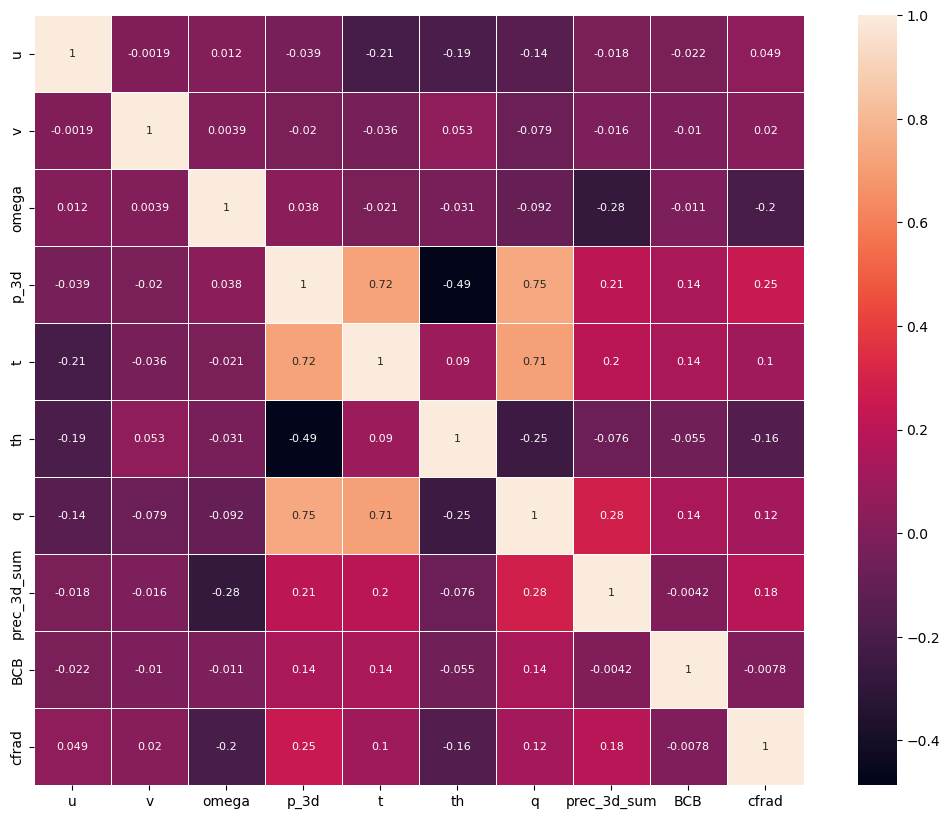

In [18]:
import seaborn as sns

# correlation matrix
corr_mat = df.drop(columns=['lat', 'lon', 'time', 'level', 'z']).corr()
fig, ax = plt.subplots(figsize=(14, 10))
ax = sns.heatmap(corr_mat, square=True, annot=True, linewidths=.5, annot_kws={"size": 8})
plt.show()

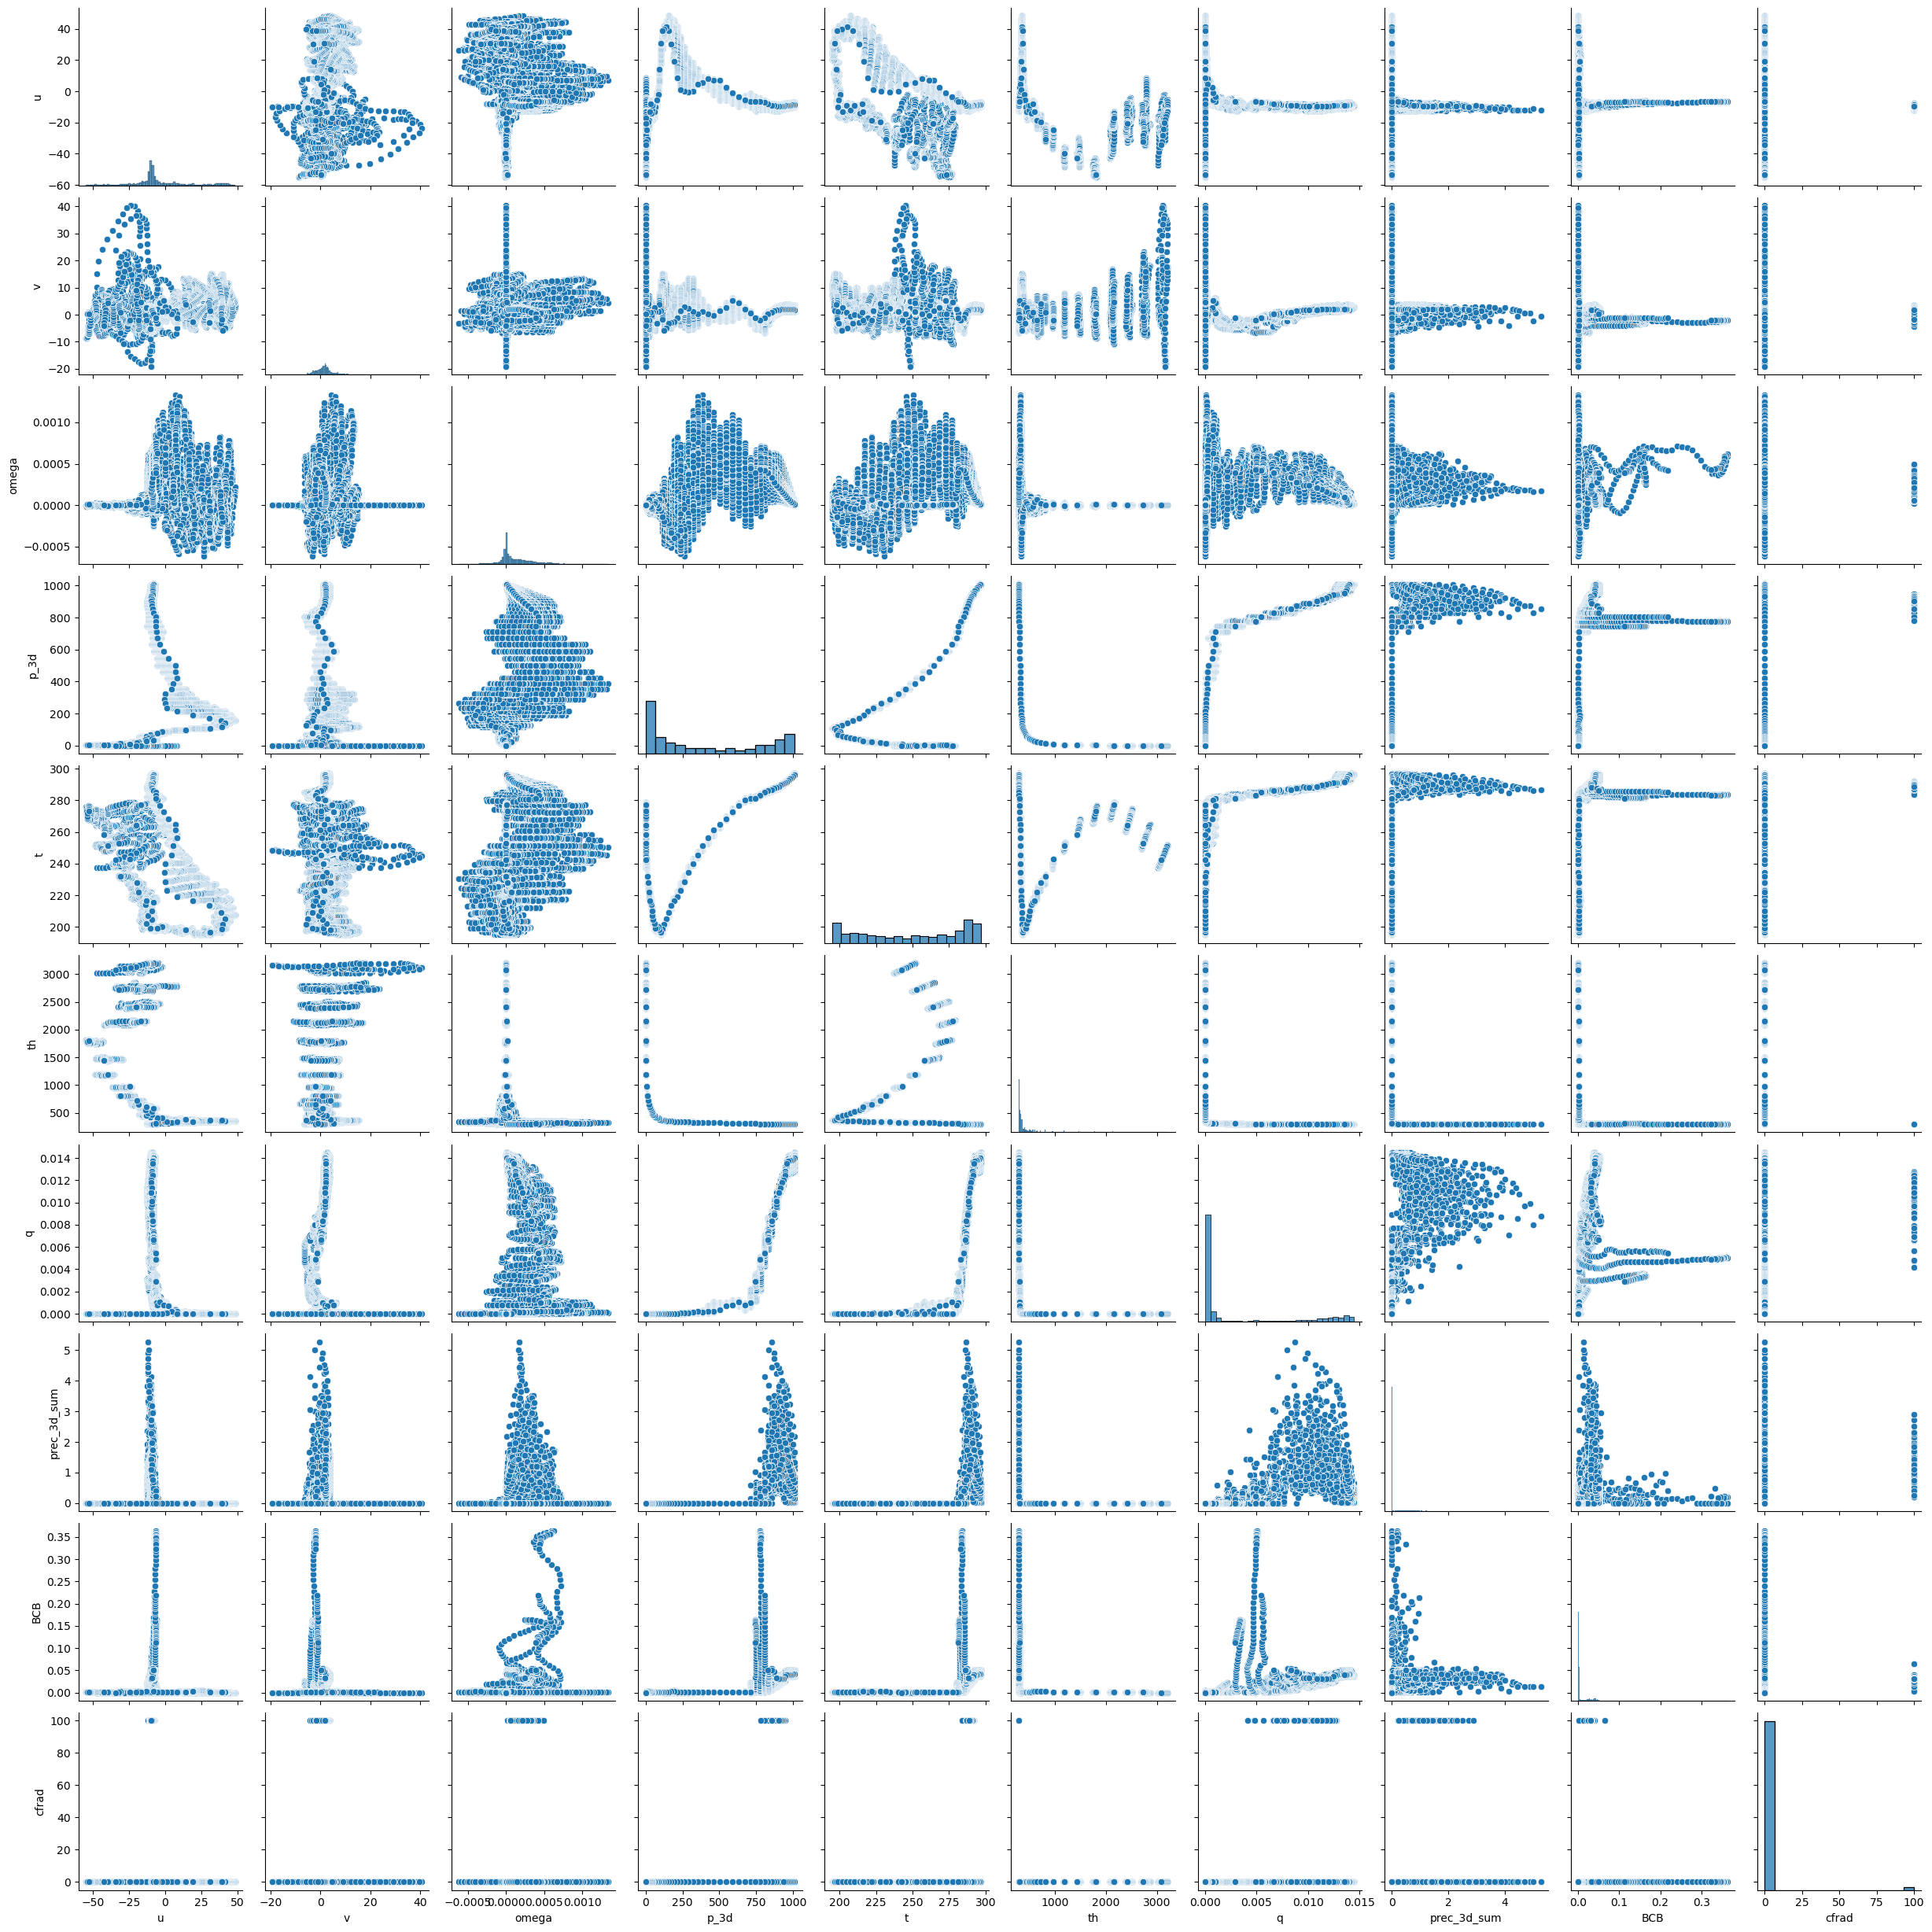

In [19]:
import seaborn as sns

# fig, ax = plt.subplots(figsize=(14, 10))
sns.pairplot(df[:10000].drop(columns=['lat', 'lon', 'time', 'level', 'z']))

plt.show()

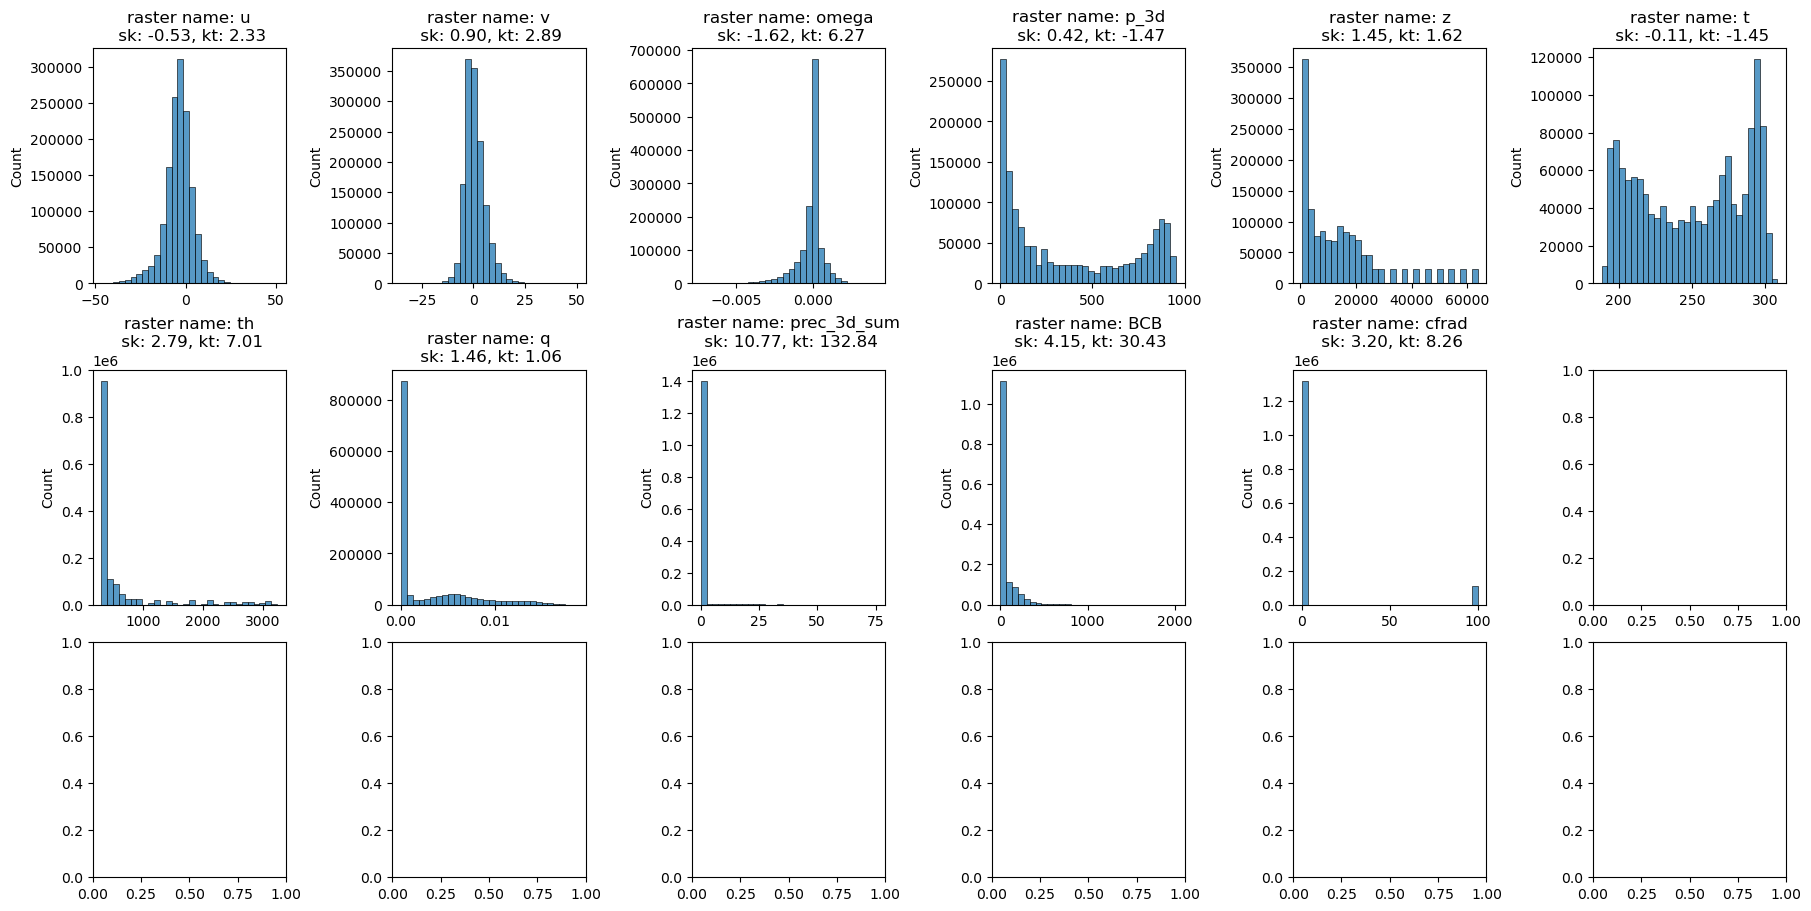

In [15]:
# Histogram
from scipy.stats import skew, kurtosis, zscore
pd.DataFrame.iteritems = pd.DataFrame.items

fig, axes = plt.subplots(nrows=3, ncols=6 , figsize=(18, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(df.drop(columns=['lat', 'lon', 'time', 'level']).iteritems()):
    i, j = divmod(index, 6)

    sns.histplot(x=column_data.values, bins=30, ax=axes[i, j])
    axes[i, j].set_title(f'raster name: {column_name}\n sk: {skew(column_data.values):.2f}, kt: {kurtosis(column_data.values):.2f}')
    axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/histrograms.png')
plt.show()

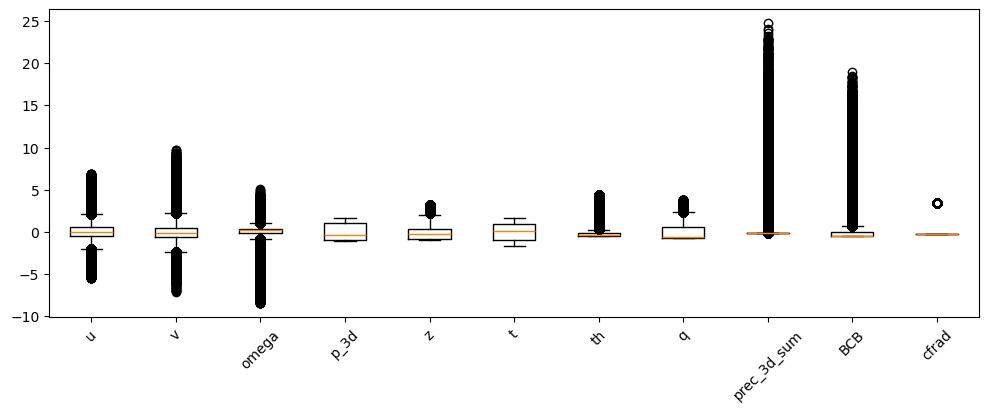

In [18]:
df_zscore = df.drop(columns=['lat', 'lon', 'time', 'level']).apply(zscore)
fig, ax = plt.subplots(figsize=(12,4))
ax.boxplot(df_zscore.values, tick_labels=df.drop(columns=['lat', 'lon', 'time', 'level']).columns, showfliers=True)
ax.tick_params(axis='x', labelrotation=45)

plt.show()

In [11]:
X = df.drop(columns=['lat', 'lon', 'time', 'level']).drop(columns=["BCB"])  # Replace "target" with your actual column name
y = df.drop(columns=['lat', 'lon', 'time', 'level'])["BCB"]

In [12]:
from sklearn.feature_selection import mutual_info_regression, f_regression
mi = mutual_info_regression(X, y)
f_test, _ = f_regression(X, y)

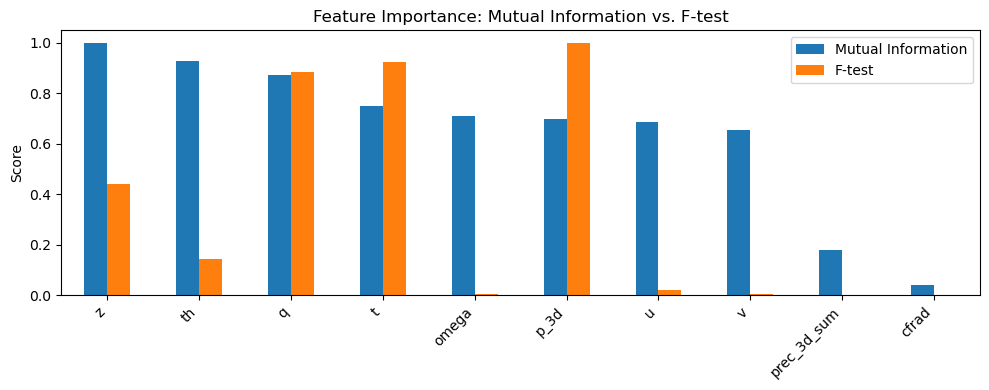

In [13]:
# Combine both series into a DataFrame
feature_scores = pd.DataFrame({
    "Mutual Information": mi / np.max(mi),
    "F-test": f_test / np.max(f_test)
}, index=X.columns)

# Sort by one of the scores (e.g., Mutual Information)
feature_scores = feature_scores.sort_values("Mutual Information", ascending=False)

# Plot as grouped bars
feature_scores.plot(kind='bar', figsize=(10, 4))

plt.title("Feature Importance: Mutual Information vs. F-test")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe = RFE(estimator=LinearRegression(), n_features_to_select=8)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=8)

In [17]:
# Get selected features (boolean mask)
selected_mask = rfe.support_

# Get feature rankings (lower = better)
ranking = rfe.ranking_

# Display selected features
selected_features = X.columns[selected_mask]
print("Selected features:", selected_features)

# Full ranking
rfe_results = pd.DataFrame({
    'Feature': X.columns,
    'Selected': selected_mask,
    'Ranking': ranking
}).sort_values(by="Ranking")

print(rfe_results)

Selected features: Index(['u', 'v', 'omega', 't', 'th', 'q', 'prec_3d_sum', 'cfrad'], dtype='object')
       Feature  Selected  Ranking
0            u      True        1
1            v      True        1
2        omega      True        1
5            t      True        1
7            q      True        1
6           th      True        1
9        cfrad      True        1
8  prec_3d_sum      True        1
4            z     False        2
3         p_3d     False        3


In [19]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor().fit(X, y)
importances = rf.feature_importances_

In [20]:
# Wrap in a DataFrame for clarity
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

       Feature  Importance
6           th    0.781710
3         p_3d    0.085104
7            q    0.064482
4            z    0.034494
2        omega    0.016016
0            u    0.011718
5            t    0.003217
1            v    0.002841
8  prec_3d_sum    0.000318
9        cfrad    0.000099


In [ ]:
import shap
explainer = shap.Explainer(rf.predict, X)
shap_values = explainer(X)
shap.plots.bar(shap_values)

### Add Static Attributes to the dataloader

In [4]:
from datetime import datetime, timedelta

# Define a function to convert fractional years to readable dates
def fractional_year_to_date(fractional_year):
    year = int(fractional_year)
    days_in_year = (fractional_year - year) * 365  # Approximation assuming 365 days in a year
    date = datetime(year, 1, 1) + timedelta(days_in_year)
    return date

In [9]:
# ever_br_early, ever_nd_early, cold_br_early, crops_herb, crops_woody -> zero values
ds1 = xr.open_dataset('/home/serfani/serfani_data1/static_attrs/V144x90_EntMM16_lc_max_trimmed_scaled_nocrops.ext.nc', decode_times=False)
ds2 = xr.open_dataset('/home/serfani/serfani_data1/static_attrs/V144x90_EntMM16_lai_trimmed_scaled_ext.nc', decode_times=False)

# Iterate through the variables and print their attributes
for var_name, var_data in ds1.data_vars.items():
    print(f"Variable: {var_name}, {var_data.min():.2f}, {var_data.max():.2f}")

Variable: ever_br_early, 0.00, 0.00
Variable: ever_br_late, 0.00, 1.00
Variable: ever_nd_early, 0.00, 0.00
Variable: ever_nd_late, 0.00, 1.00
Variable: cold_br_early, 0.00, 0.00
Variable: cold_br_late, 0.00, 1.00
Variable: drought_br, 0.00, 0.99
Variable: decid_nd, 0.00, 1.00
Variable: cold_shrub, 0.00, 1.00
Variable: arid_shrub, 0.00, 1.00
Variable: c3_grass_per, 0.00, 1.00
Variable: c4_grass, 0.00, 1.00
Variable: c3_grass_ann, 0.00, 1.00
Variable: c3_grass_arct, 0.00, 1.00
Variable: crops_herb, 0.00, 0.00
Variable: crops_woody, 0.00, 0.00
Variable: bare_bright, 0.00, 0.93
Variable: bare_dark, 0.00, 0.70


In [10]:
ds1 = ds1.drop_vars(['ever_br_early', 'ever_nd_early', 'cold_br_early', 'crops_herb', 'crops_woody'])
ds2 = ds2.drop_vars(['ever_br_early', 'ever_nd_early', 'cold_br_early', 'crops_herb', 'crops_woody'])

In [3]:
for root, dirs, files in os.walk('/home/serfani/serfani_data1/E33OMA'):
    
    sorted_files = sorted(files)
    ds_list = [os.path.join(root, file) for file in sorted_files if (file.split(".")[1] == 'xaijE33oma_ai' and file.split(".")[0] in ['ANN1950', 'ANN1951'])]

ds3 = xr.open_mfdataset(ds_list, decode_times=False).isel(time=0).drop_vars('time')
ds3 = ds3[['axyp', 'landfr', 'ocnfr']] # 'oicefr'

In [6]:
ds_list

['/home/serfani/serfani_data1/E33OMA/ANN1950.xaijE33oma_ai.nc',
 '/home/serfani/serfani_data1/E33OMA/ANN1951.xaijE33oma_ai.nc']

In [13]:
# Iterate through the variables and print their attributes
rename_dict = {}
for var_name, var_data in ds2.data_vars.items():
    rename_dict[f'{var_name}'] = f'lai_{var_name}'

# Rename the variables
ds2_renamed = ds2.rename(rename_dict)
ds2_renamed

<xarray.Dataset> Size: 8MB
Dimensions:            (lon: 144, lat: 90, time: 12)
Coordinates:
  * lon                (lon) float32 576B -178.8 -176.2 -173.8 ... 176.2 178.8
  * lat                (lat) float32 360B -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
  * time               (time) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/13)
    lai_ever_br_late   (time, lat, lon) float32 622kB ...
    lai_ever_nd_late   (time, lat, lon) float32 622kB ...
    lai_cold_br_late   (time, lat, lon) float32 622kB ...
    lai_drought_br     (time, lat, lon) float32 622kB ...
    lai_decid_nd       (time, lat, lon) float32 622kB ...
    lai_cold_shrub     (time, lat, lon) float32 622kB ...
    ...                 ...
    lai_c3_grass_per   (time, lat, lon) float32 622kB ...
    lai_c4_grass       (time, lat, lon) float32 622kB ...
    lai_c3_grass_ann   (time, lat, lon) float32 622kB ...
    lai_c3_grass_arct  (time, lat, lon) float32 622kB ...
    lai_bare_bright    (time, lat, lon) float32 622kB ...
    lai_bare_dark      (time, lat, lon) float32 622kB ...
Attributes:
    xlabel:       Monthly Leaf Area Index, 16 plant types, EXT1, m^2 leaf/m^2...
    history:      MODIS, Average of 2001-2005, Version 4, March 2014
    institution:  NASA/GISS  N.Kiang, I.Aleinov

In [14]:
# Assign the lat values from ds3 to ds1
ds1['lat'] = ds3['lat'].values
ds2_renamed['lat'] = ds3['lat'].values

In [19]:
# Merge the datasets
merged_ds = xr.merge([ds1, ds3, ds2_renamed]).chunk({'lat': 90, 'lon': 144, 'time': 1})
merged_ds.to_netcdf('/home/serfani/serfani_data1/static_attrs/static_attrs.nc')

### Adding Monthly Attributes

In [ ]:
monthly_attributes= ['axyp', 'landfr', 'oclkicefr', 'pwatfr', 'soilfr', 'vsfr', 'snowicefr', 'wtbl_depth', 'sss', 'prsurfq', 'pot_evap']

for root, dirs, files in os.walk('/discover/nobackup/sebauer1/E33oma_ai/output/'):
    
    sorted_files = sorted(files)
    ds_ma_list = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'xaijE33oma_ai']

ds_ma = xr.open_mfdataset(ds_ma_list, decode_times=False)

In [ ]:
ds_ma = ds_ma[monthly_attributes]
ds_ma['time'] = [fractional_year_to_date(date) for date in ds_ma['time'].values]

In [ ]:
df1 = ds1.to_dataframe(dim_order=['lat', 'lon', 'time']).reset_index()
df1['month'] = df1['time'].dt.month

In [ ]:
df2 = ds_ma.to_dataframe(dim_order=['lat', 'lon', 'time']).reset_index()
df2['month'] = df2['time'].dt.month

In [ ]:
df = pd.merge(df1, df2, on=['lat', 'lon', 'month'], how='left')
df.rename({'time_x': 'time_hr', 'seasalt_x': 'seasalt_hr', 'time_y': 'time_mn', 'seasalt_y': 'seasalt_mn'}, axis=1, inplace=True)
df.info()